<a href="https://colab.research.google.com/github/jailer2024/JAILER-CHAPID-SE-ALES-Y-SISTEMAS/blob/main/copia_de_pregunta4_parcial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
!pip install matplotlib-venn

In [219]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [220]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

In [221]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [222]:
!pip install cartopy
import cartopy

https://drive.google.com/file/d/1jDbgsCRZbSVjJlRGdU8YZae2bz2OV204/view?usp=sharing

In [223]:
# ID del archivo en Google Drive
FILEID="137dQQdRyuKlpbtA8GD9y-zP-XIWcZNjh"
FILENAME="clave2.wav"  # Nombre del archivo de salida

# Descargar el archivo desde Google Drive y guardarlo como audioClaveSeñal.wav
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=$FILEID" -O $FILENAME

# Verificar si el archivo se descargó correctamente
!ls -lh $FILENAME


--2025-02-09 04:40:07--  https://docs.google.com/uc?export=download&id=137dQQdRyuKlpbtA8GD9y-zP-XIWcZNjh
Resolving docs.google.com (docs.google.com)... 142.251.179.113, 142.251.179.139, 142.251.179.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.179.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=137dQQdRyuKlpbtA8GD9y-zP-XIWcZNjh&export=download [following]
--2025-02-09 04:40:07--  https://drive.usercontent.google.com/download?id=137dQQdRyuKlpbtA8GD9y-zP-XIWcZNjh&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.63.132, 2607:f8b0:4004:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.63.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3545166 (3.4M) [audio/wav]
Saving to: ‘clave2.wav’

clave2.wav          100%[===================>]   3.38M  --.-KB/s    in 0.06s   

202

Frecuencia de muestreo: 48000 Hz
Número de muestras: 1772544
Forma del audio: (1772544,)
Duración del audio: 36.93 segundos


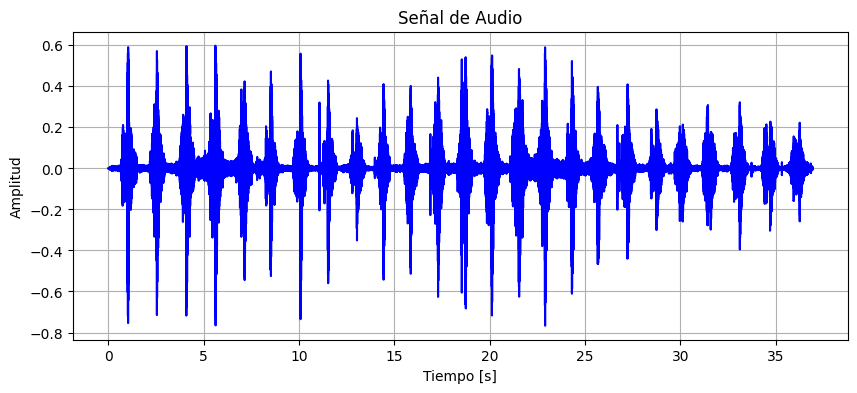

In [224]:
import soundfile as sf  # Librería para leer archivos de audio

# Cargar el archivo de audio descargado
file_path = "clave2.wav"  # Ruta del archivo
audio_data, sample_rate = sf.read(file_path)

# Mostrar información básica del audio
print(f"Frecuencia de muestreo: {sample_rate} Hz")
print(f"Número de muestras: {len(audio_data)}")
print(f"Forma del audio: {audio_data.shape}")

# Si el audio tiene dos canales, convertirlo a mono
if len(audio_data.shape) == 2:
    audio_data = audio_data.mean(axis=1)  # Promediar los canales estéreo para obtener mono
    print("Audio convertido a mono.")

# Verificar duración del audio en segundos
duracion = len(audio_data) / sample_rate
print(f"Duración del audio: {duracion:.2f} segundos")

# Graficar la señal de audio
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, duracion, len(audio_data))  # Vector de tiempo
plt.figure(figsize=(10, 4))
plt.plot(t, audio_data, color="blue")
plt.title("Señal de Audio")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


#Divicion por segmentos del audio palabra clave


In [225]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf

def segment_audio_by_energy(audio_path, output_folder, frame_length=1024, hop_length=256, padding=0.05, merge_gap=0.3):
    # Cargar el audio asegurando una frecuencia de muestreo fija
    y, sr = librosa.load(audio_path, sr=16000, mono=True)  # Convertimos a 16 kHz y mono

    # Calcular la energía de la señal
    energy = np.array([
        np.sum(np.square(y[i : i + frame_length]))
        for i in range(0, len(y), hop_length)
    ])

    # Normalizar la energía
    energy = energy / np.max(energy)

    # Establecer un umbral dinámico basado en el percentil 75 en lugar de un valor fijo
    energy_threshold = np.percentile(energy, 55)

    # Encontrar regiones con energía mayor al umbral
    voiced_frames = energy > energy_threshold

    # Determinar los índices de los segmentos hablados
    change_points = np.diff(voiced_frames.astype(int))
    start_indices = np.where(change_points == 1)[0] * hop_length
    end_indices = np.where(change_points == -1)[0] * hop_length

    if len(end_indices) == 0 or (len(start_indices) > 0 and start_indices[0] > end_indices[0]):
        end_indices = np.append(end_indices, len(y))
    if len(start_indices) == 0 or (len(end_indices) > 0 and end_indices[-1] < start_indices[-1]):
        start_indices = np.insert(start_indices, 0, 0)

    # Filtrar segmentos pequeños (ruido)
    min_duration = 0.1 * sr  # Reducimos a 100 ms para evitar cortes de palabras
    valid_segments = [(start, end) for start, end in zip(start_indices, end_indices) if end - start > min_duration]

    # Unir segmentos muy cercanos (para evitar cortes en sílabas)
    merged_segments = []
    prev_start, prev_end = valid_segments[0]
    for start, end in valid_segments[1:]:
        if start - prev_end < merge_gap * sr:  # Si la pausa es menor que 300 ms, unir segmentos
            prev_end = end
        else:
            merged_segments.append((prev_start, prev_end))
            prev_start, prev_end = start, end
    merged_segments.append((prev_start, prev_end))  # Agregar el último segmento

    # Aplicar padding antes y después de cada segmento
    padding_samples = int(padding * sr)
    merged_segments = [(max(0, start - padding_samples), min(len(y), end + padding_samples)) for start, end in merged_segments]

    # Crear la carpeta de salida si no existe
    os.makedirs(output_folder, exist_ok=True)

    # Guardar cada segmento como un archivo separado
    segment_links = []
    for i, (start, end) in enumerate(merged_segments):
        segment = y[start:end]
        output_file = os.path.join(output_folder, f'segment_{i+1}.wav')
        sf.write(output_file, segment, sr)
        print(f'Segmento {i+1} guardado: {output_file}')
        segment_links.append((f"audioClave{i+1}", output_file, 1))  # Nombre, ruta, etiqueta

    return segment_links  # Retornar la lista con los datos

# Uso del código
input_audio = "clave2.wav"
output_directory = "segmented_audios"
segments_data = segment_audio_by_energy(input_audio, output_directory)

Segmento 1 guardado: segmented_audios/segment_1.wav
Segmento 2 guardado: segmented_audios/segment_2.wav
Segmento 3 guardado: segmented_audios/segment_3.wav
Segmento 4 guardado: segmented_audios/segment_4.wav
Segmento 5 guardado: segmented_audios/segment_5.wav
Segmento 6 guardado: segmented_audios/segment_6.wav
Segmento 7 guardado: segmented_audios/segment_7.wav
Segmento 8 guardado: segmented_audios/segment_8.wav
Segmento 9 guardado: segmented_audios/segment_9.wav
Segmento 10 guardado: segmented_audios/segment_10.wav
Segmento 11 guardado: segmented_audios/segment_11.wav
Segmento 12 guardado: segmented_audios/segment_12.wav
Segmento 13 guardado: segmented_audios/segment_13.wav
Segmento 14 guardado: segmented_audios/segment_14.wav
Segmento 15 guardado: segmented_audios/segment_15.wav
Segmento 16 guardado: segmented_audios/segment_16.wav
Segmento 17 guardado: segmented_audios/segment_17.wav
Segmento 18 guardado: segmented_audios/segment_18.wav
Segmento 19 guardado: segmented_audios/segment

In [226]:
print (output_directory)

segmented_audios


# Audios Palabra Clave

In [227]:
import IPython.display as ipd

# Escuchar un segmento específico (ejemplo: segmento_1.wav)
ipd.Audio("segmented_audios/segment_2.wav")

In [228]:
# Escuchar un segmento específico (ejemplo: segmento_1.wav)
ipd.Audio("segmented_audios/segment_2.wav")

In [229]:
ipd.Audio("segmented_audios/segment_3.wav")

In [230]:
ipd.Audio("segmented_audios/segment_4.wav")

In [231]:
ipd.Audio("segmented_audios/segment_5.wav")

In [232]:
ipd.Audio("segmented_audios/segment_6.wav")

In [233]:
ipd.Audio("segmented_audios/segment_7.wav")

In [234]:
ipd.Audio("segmented_audios/segment_8.wav")

In [235]:
ipd.Audio("segmented_audios/segment_9.wav")

In [236]:
ipd.Audio("segmented_audios/segment_10.wav")

In [237]:
ipd.Audio("segmented_audios/segment_11.wav")

In [238]:
ipd.Audio("segmented_audios/segment_12.wav")

In [239]:
ipd.Audio("segmented_audios/segment_13.wav")

In [240]:
ipd.Audio("segmented_audios/segment_14.wav")

In [241]:
ipd.Audio("segmented_audios/segment_15.wav")

In [242]:
ipd.Audio("segmented_audios/segment_16.wav")

In [243]:
ipd.Audio("segmented_audios/segment_17.wav")

In [244]:
ipd.Audio("segmented_audios/segment_18.wav")

In [245]:
ipd.Audio("segmented_audios/segment_19.wav")

In [246]:
ipd.Audio("segmented_audios/segment_20.wav")

In [247]:
ipd.Audio("segmented_audios/segment_21.wav")

In [248]:
ipd.Audio("segmented_audios/segment_22.wav")

In [249]:
ipd.Audio("segmented_audios/segment_23.wav")

https://drive.google.com/file/d/1WjFCKaBfYTr3cjdPIm3W-4L3z-UNB7e_/view?usp=sharing

#Audios palabra no clave


In [250]:
# ID del archivo en Google Drive
FILEID="1WjFCKaBfYTr3cjdPIm3W-4L3z-UNB7e_"
FILENAME="noclave.wav"  # Nombre del archivo de salida

# Descargar el archivo desde Google Drive y guardarlo como audioClaveSeñal.wav
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=$FILEID" -O $FILENAME

# Verificar si el archivo se descargó correctamente
!ls -lh $FILENAME

--2025-02-09 04:40:11--  https://docs.google.com/uc?export=download&id=1WjFCKaBfYTr3cjdPIm3W-4L3z-UNB7e_
Resolving docs.google.com (docs.google.com)... 142.251.179.113, 142.251.179.139, 142.251.179.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.179.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1WjFCKaBfYTr3cjdPIm3W-4L3z-UNB7e_&export=download [following]
--2025-02-09 04:40:11--  https://drive.usercontent.google.com/download?id=1WjFCKaBfYTr3cjdPIm3W-4L3z-UNB7e_&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.63.132, 2607:f8b0:4004:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.63.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4962382 (4.7M) [audio/wav]
Saving to: ‘noclave.wav’

noclave.wav         100%[===================>]   4.73M  --.-KB/s    in 0.1s    

20

Frecuencia de muestreo: 48000 Hz
Número de muestras: 2481152
Forma del audio: (2481152,)
Duración del audio: 51.69 segundos


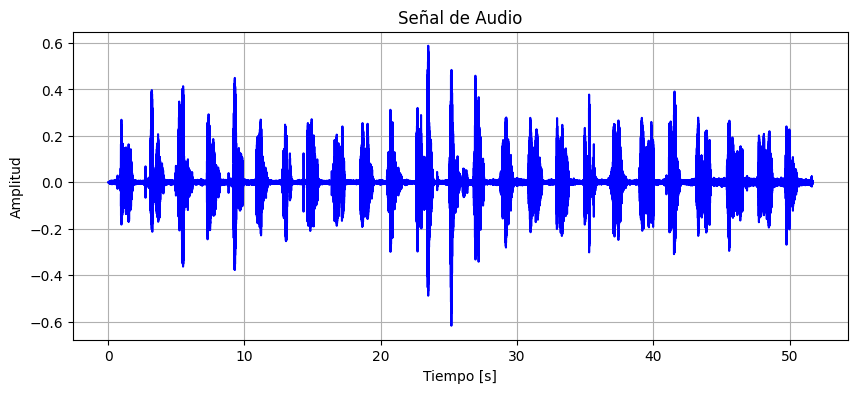

In [251]:
import soundfile as sf  # Librería para leer archivos de audio

# Cargar el archivo de audio descargado
file_path = "noclave.wav"  # Ruta del archivo
audio_data, sample_rate = sf.read(file_path)

# Mostrar información básica del audio
print(f"Frecuencia de muestreo: {sample_rate} Hz")
print(f"Número de muestras: {len(audio_data)}")
print(f"Forma del audio: {audio_data.shape}")

# Si el audio tiene dos canales, convertirlo a mono
if len(audio_data.shape) == 2:
    audio_data = audio_data.mean(axis=1)  # Promediar los canales estéreo para obtener mono
    print("Audio convertido a mono.")

# Verificar duración del audio en segundos
duracion = len(audio_data) / sample_rate
print(f"Duración del audio: {duracion:.2f} segundos")

# Graficar la señal de audio
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, duracion, len(audio_data))  # Vector de tiempo
plt.figure(figsize=(10, 4))
plt.plot(t, audio_data, color="blue")
plt.title("Señal de Audio")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


In [252]:
input_audio = "noclave.wav"
output_directory = "segmented_audiosError"
segment=segment_audio_by_energy(input_audio, output_directory)

Segmento 1 guardado: segmented_audiosError/segment_1.wav
Segmento 2 guardado: segmented_audiosError/segment_2.wav
Segmento 3 guardado: segmented_audiosError/segment_3.wav
Segmento 4 guardado: segmented_audiosError/segment_4.wav
Segmento 5 guardado: segmented_audiosError/segment_5.wav
Segmento 6 guardado: segmented_audiosError/segment_6.wav
Segmento 7 guardado: segmented_audiosError/segment_7.wav
Segmento 8 guardado: segmented_audiosError/segment_8.wav
Segmento 9 guardado: segmented_audiosError/segment_9.wav
Segmento 10 guardado: segmented_audiosError/segment_10.wav
Segmento 11 guardado: segmented_audiosError/segment_11.wav
Segmento 12 guardado: segmented_audiosError/segment_12.wav
Segmento 13 guardado: segmented_audiosError/segment_13.wav
Segmento 14 guardado: segmented_audiosError/segment_14.wav
Segmento 15 guardado: segmented_audiosError/segment_15.wav
Segmento 16 guardado: segmented_audiosError/segment_16.wav
Segmento 17 guardado: segmented_audiosError/segment_17.wav
Segmento 18 gua

# Segmentos palabra no clave


In [253]:
ipd.Audio( "noclave.wav")

In [254]:
ipd.Audio("segmented_audiosError/segment_1.wav")

In [255]:
ipd.Audio("segmented_audiosError/segment_2.wav")

In [256]:
ipd.Audio("segmented_audiosError/segment_3.wav")

In [257]:
ipd.Audio("segmented_audiosError/segment_4.wav")

In [258]:
ipd.Audio("segmented_audiosError/segment_5.wav")

In [259]:
ipd.Audio("segmented_audiosError/segment_6.wav")

In [260]:
ipd.Audio("segmented_audiosError/segment_7.wav")

In [261]:
ipd.Audio("segmented_audiosError/segment_8.wav")

In [262]:
ipd.Audio("segmented_audiosError/segment_9.wav")

In [263]:
ipd.Audio("segmented_audiosError/segment_10.wav")

In [264]:
ipd.Audio("segmented_audiosError/segment_11.wav")

In [265]:
ipd.Audio("segmented_audiosError/segment_12.wav")

In [266]:
ipd.Audio("segmented_audiosError/segment_13.wav")

In [267]:
ipd.Audio("segmented_audiosError/segment_14.wav")

In [268]:
ipd.Audio("segmented_audiosError/segment_15.wav")

In [269]:
ipd.Audio("segmented_audiosError/segment_16.wav")

In [270]:
ipd.Audio("segmented_audiosError/segment_17.wav")

In [271]:
ipd.Audio("segmented_audiosError/segment_18.wav")

In [272]:
ipd.Audio("segmented_audiosError/segment_19.wav")

In [273]:
ipd.Audio("segmented_audiosError/segment_20.wav")

In [274]:
ipd.Audio("segmented_audiosError/segment_21.wav")

In [275]:
ipd.Audio("segmented_audiosError/segment_22.wav")

In [276]:
ipd.Audio("segmented_audiosError/segment_23.wav")

In [277]:
ipd.Audio("segmented_audiosError/segment_24.wav")

In [278]:
ipd.Audio("segmented_audiosError/segment_25.wav")

# Bases de datos palabras clave y no clave

In [279]:
import os
import numpy as np
import librosa
import scipy.fftpack as fft
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Función para calcular el espectro de Fourier
def compute_spectrum(signal, sr, n_fft=1024):
    spectrum = np.abs(fft.fft(signal, n=n_fft))  # Magnitud del espectro
    spectrum = spectrum / np.min(spectrum)  # Normalizar por el valor minimo
    return spectrum[:n_fft // 2]  # Usamos solo la mitad (simetría de la FFT)

# Función para procesar una carpeta de audios y crear la base de datos
def create_database(folder_path, sr=22050):
    database = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):  # Solo procesar archivos .wav
            file_path = os.path.join(folder_path, filename)
            signal, _ = librosa.load(file_path, sr=sr)  # Cargar el audio
            spectrum = compute_spectrum(signal, sr)  # Calcular el espectro
            database.append(spectrum)  # Agregar a la base de datos
            filenames.append(filename)  # Guardar el nombre del archivo
    return np.array(database), filenames

# Rutas de las carpetas en Colab
correct_folder = "/content/segmented_audios"  # Carpeta con la palabra correcta
error_folder = "/content/segmented_audiosError"  # Carpeta con palabras incorrectas

# Crear las bases de datos
correct_database, correct_filenames = create_database(correct_folder)  # Base de datos para la palabra correcta
error_database, error_filenames = create_database(error_folder)  # Base de datos para palabras incorrectas

# Combinar las bases de datos y crear etiquetas
X = np.vstack((correct_database, error_database))  # Combinar espectros
labels = np.array([1] * len(correct_database) + [0] * len(error_database))  # Etiquetas (1: correcta, 0: incorrecta)
filenames = correct_filenames + error_filenames  # Nombres de los archivos

# Covercion en 2D


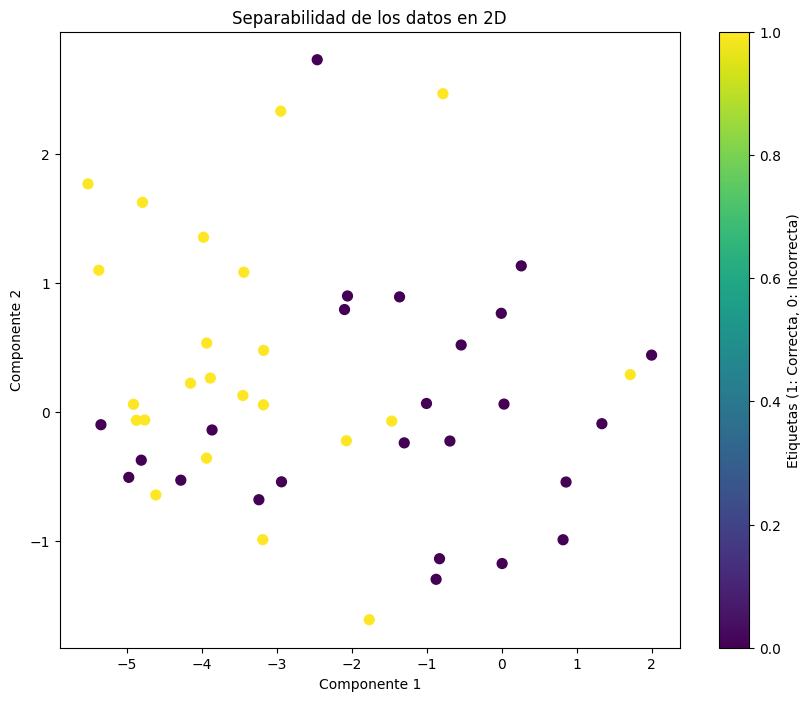

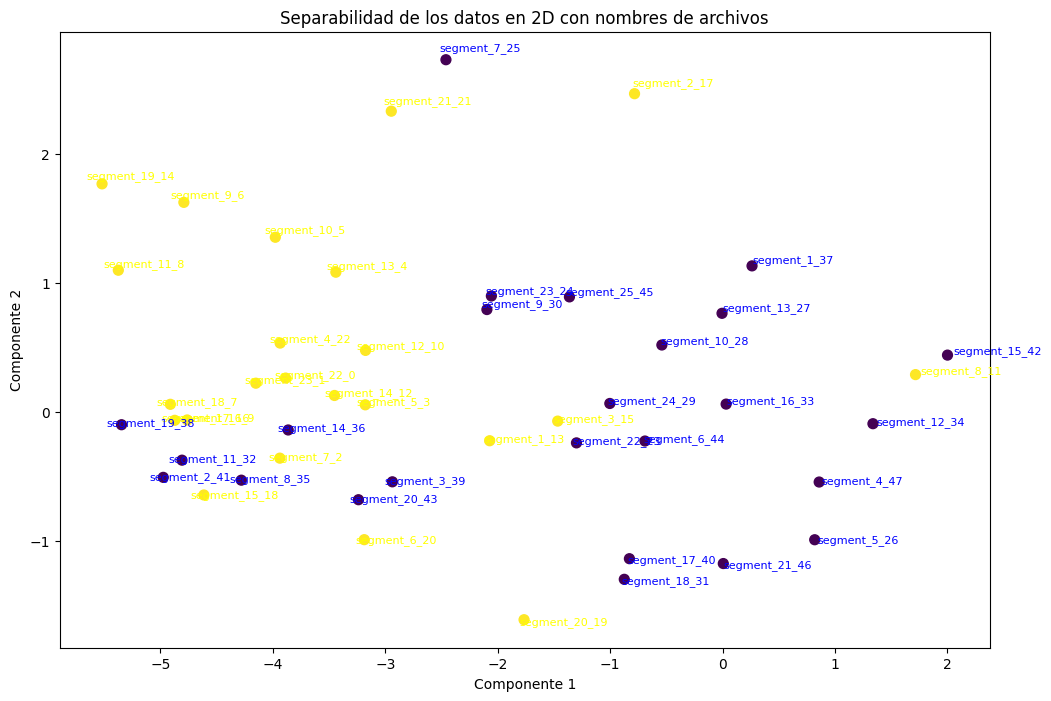

Bases de datos creadas y guardadas correctamente.
Tamaño de la base de datos correcta: 23
Tamaño de la base de datos de errores: 25


In [280]:
# Reducción a 2D usando t-SNE o PCA
fmax = 7000  # Considerar solo frecuencias hasta fmax Hz
red_ = TSNE(perplexity=20, n_components=2, random_state=123, learning_rate='auto', init='pca')
# red_ = PCA(n_components=2, random_state=123)  # Alternativa: PCA
X_2D = red_.fit_transform(X[:, :fmax])  # Reducir a 2D

# Graficar separabilidad 2D
plt.figure(figsize=(10, 8))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(label="Etiquetas (1: Correcta, 0: Incorrecta)")
plt.title("Separabilidad de los datos en 2D")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

# Graficar con nombres de archivos
plt.figure(figsize=(12, 8))
colors = ["blue", "yellow"]  # Colores para las etiquetas
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='viridis', s=50)
for i, tex in enumerate(filenames):
    plt.text(X_2D[i, 0] * 1.025, X_2D[i, 1] * 1.025, tex[:-4] + f"_{i}", fontsize=8, color=colors[labels[i]])
plt.title("Separabilidad de los datos en 2D con nombres de archivos")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

# Guardar las bases de datos en archivos
with open("correct_database.pkl", "wb") as f:
    pickle.dump(correct_database, f)

with open("error_database.pkl", "wb") as f:
    pickle.dump(error_database, f)

print("Bases de datos creadas y guardadas correctamente.")
print(f"Tamaño de la base de datos correcta: {len(correct_database)}")
print(f"Tamaño de la base de datos de errores: {len(error_database)}")

# Subir audio a comparar (NO FUNCIONA)


In [281]:
import pickle
from pydub import AudioSegment
from scipy.spatial.distance import euclidean

# Función para convertir un archivo de audio a WAV
def convert_to_wav(input_file, output_file):
    audio = AudioSegment.from_file(input_file)
    audio.export(output_file, format="wav")
    print(f"Archivo convertido a WAV: {output_file}")

# Función para calcular el espectro de Fourier
def compute_spectrum(signal, sr, n_fft=1024):
    spectrum = np.abs(fft.fft(signal, n=n_fft))  # Magnitud del espectro
    spectrum = spectrum[:n_fft // 2]  # Usamos solo la mitad (simetría de la FFT)
    spectrum = spectrum / np.max(spectrum)  # Normalizar el espectro
    return spectrum

# Función para calcular el índice del valor mínimo en el espectro
def compute_min_spectrum_index(signal, sr, n_fft=1024):
    spectrum = compute_spectrum(signal, sr, n_fft)
    min_index = np.argmin(spectrum)  # Índice del valor mínimo en el espectro
    return min_index

# Función para cortar el audio basado en la energía (igual que en tu código)
def segment_audio_by_energy(y, sr, frame_length=1024, hop_length=256, padding=0.05, merge_gap=0.3):
    # Calcular la energía de la señal
    energy = np.array([
        np.sum(np.square(y[i : i + frame_length]))
        for i in range(0, len(y), hop_length)
    ])

    # Normalizar la energía
    energy = energy / np.max(energy)

    # Establecer un umbral dinámico basado en el percentil 55
    energy_threshold = np.percentile(energy, 55)

    # Encontrar regiones con energía mayor al umbral
    voiced_frames = energy > energy_threshold

    # Determinar los índices de los segmentos hablados
    change_points = np.diff(voiced_frames.astype(int))
    start_indices = np.where(change_points == 1)[0] * hop_length
    end_indices = np.where(change_points == -1)[0] * hop_length

    if len(end_indices) == 0 or (len(start_indices) > 0 and start_indices[0] > end_indices[0]):
        end_indices = np.append(end_indices, len(y))
    if len(start_indices) == 0 or (len(end_indices) > 0 and end_indices[-1] < start_indices[-1]):
        start_indices = np.insert(start_indices, 0, 0)

    # Filtrar segmentos pequeños (ruido)
    min_duration = 0.1 * sr  # Reducimos a 100 ms para evitar cortes de palabras
    valid_segments = [(start, end) for start, end in zip(start_indices, end_indices) if end - start > min_duration]

    # Unir segmentos muy cercanos (para evitar cortes en sílabas)
    merged_segments = []
    prev_start, prev_end = valid_segments[0]
    for start, end in valid_segments[1:]:
        if start - prev_end < merge_gap * sr:  # Si la pausa es menor que 300 ms, unir segmentos
            prev_end = end
        else:
            merged_segments.append((prev_start, prev_end))
            prev_start, prev_end = start, end
    merged_segments.append((prev_start, prev_end))  # Agregar el último segmento

    # Aplicar padding antes y después de cada segmento
    padding_samples = int(padding * sr)
    merged_segments = [(max(0, start - padding_samples), min(len(y), end + padding_samples)) for start, end in merged_segments]

    return merged_segments

# Función para comparar un índice mínimo con una base de datos usando distancia euclidiana
def compare_with_database(input_min_index, database):
    min_distance = float('inf')
    for db_spectrum in database:  # Iterate over spectra in the database
        db_min_index = np.argmin(db_spectrum)  # Get the index of the minimum value in the spectrum
        distance = euclidean([input_min_index], [db_min_index])  # Calculate distance using the minimum indices
        if distance < min_distance:
            min_distance = distance
    return min_distance

# Subir un archivo de audio
uploaded = files.upload()
uploaded_file = list(uploaded.keys())[0]

# Convertir a WAV si no está en formato WAV
if not uploaded_file.endswith(".wav"):
    output_file = "converted_audio.wav"
    convert_to_wav(uploaded_file, output_file)
    audio_file = output_file
else:
    audio_file = uploaded_file

# Cargar el archivo de audio
signal, sr = librosa.load(audio_file, sr=16000, mono=True)  # Convertimos a 16 kHz y mono

# Cortar el audio basado en la energía (usando la misma lógica que en la base de datos)
segments = segment_audio_by_energy(signal, sr)

# Si hay segmentos, tomar el primero (asumimos que es el más relevante)
if len(segments) > 0:
    start, end = segments[0]
    trimmed_signal = signal[start:end]
else:
    trimmed_signal = signal  # Si no se encuentra ningún segmento, usar la señal completa

# Calcular el índice del valor mínimo en el espectro del audio subido
input_min_index = compute_min_spectrum_index(trimmed_signal, sr)

# Cargar las bases de datos
with open("correct_database.pkl", "rb") as f:
    correct_database = pickle.load(f)

with open("error_database.pkl", "rb") as f:
    error_database = pickle.load(f)

# Comparar con la base de datos de palabras correctas
distance_correct = compare_with_database(input_min_index, correct_database)

# Comparar con la base de datos de palabras incorrectas
distance_error = compare_with_database(input_min_index, error_database)

# Tomar una decisión
if distance_correct < distance_error:
    print("El audio pertenece a la palabra correcta.")
else:
    print("El audio pertenece a una palabra incorrecta.")

ModuleNotFoundError: No module named 'pydub'

HHHHHHH

In [ ]:
# Instalar librerías necesarias
!pip install pydub
!pip install librosa

import os
import numpy as np
import librosa
import scipy.fftpack as fft
import pickle
from pydub import AudioSegment
from google.colab import files
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr

# Función para convertir un archivo de audio a WAV
def convert_to_wav(input_file, output_file):
    audio = AudioSegment.from_file(input_file)
    audio.export(output_file, format="wav")
    print(f"Archivo convertido a WAV: {output_file}")

# Función para calcular el espectro de Fourier
def compute_spectrum(signal, sr, n_fft=1024):
    spectrum = np.abs(fft.fft(signal, n=n_fft))  # Magnitud del espectro
    spectrum = spectrum[:n_fft // 2]  # Usamos solo la mitad (simetría de la FFT)
    spectrum = spectrum / np.max(spectrum)  # Normalizar el espectro
    return spectrum

# Función para comparar un espectro con una base de datos usando correlación
def compare_with_database(input_spectrum, database, threshold=0.8):
    max_correlation = -1
    for db_spectrum in database:
        correlation, _ = pearsonr(input_spectrum, db_spectrum)  # Correlación de Pearson
        if correlation > max_correlation:
            max_correlation = correlation
    return max_correlation > threshold

# Subir un archivo de audio
uploaded = files.upload()
uploaded_file = list(uploaded.keys())[0]

# Convertir a WAV si no está en formato WAV
if not uploaded_file.endswith(".wav"):
    output_file = "converted_audio.wav"
    convert_to_wav(uploaded_file, output_file)
    audio_file = output_file
else:
    audio_file = uploaded_file

# Cargar el archivo de audio
signal, sr = librosa.load(audio_file, sr=None)

# Calcular el espectro del audio subido
input_spectrum = compute_spectrum(signal, sr)

# Cargar las bases de datos
with open("correct_database.pkl", "rb") as f:
    correct_database = pickle.load(f)

with open("error_database.pkl", "rb") as f:
    error_database = pickle.load(f)

# Comparar con la base de datos de palabras correctas
is_correct = compare_with_database(input_spectrum, correct_database, threshold=0.5)

# Comparar con la base de datos de palabras incorrectas
is_error = compare_with_database(input_spectrum, error_database, threshold=0.5)

# Tomar una decisión
if is_correct:
    print("El audio pertenece a la palabra correcta.")
else:
    print("El audio pertenece a una palabra incorrecta.")